In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# to keep the notebook cleaner, we disable warnings for now
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Loading data
First we have to load data from the various tab-separated files

Source: https://archive.ics.uci.edu/ml/datasets/diabetes

In [2]:
path = 'data/raw/'
df = pd.DataFrame()
df_list=[]
#df_list = [pd.read_csv(path + file ,sep='\t',header=None) for file in os.listdir(path)]
for i,file in enumerate(os.listdir(path)):
    df_temp = pd.read_csv(path + file ,sep='\t',header=None)
    df_temp['id_patient'] = i
    df = df.append(df_temp,ignore_index=True)

In [3]:
df.columns = ['date', 'time', 'code', 'value','id_patient']

In [4]:
mapper = {
33: 'Regular insulin dose',
34: 'NPH insulin dose',
35: 'UltraLente insulin dose',
48: 'Unspecified blood glucose measurement',
57: 'Unspecified blood glucose measurement',
58: 'Pre-breakfast blood glucose measurement',
59: 'Post-breakfast blood glucose measurement',
60: 'Pre-lunch blood glucose measurement',
61: 'Post-lunch blood glucose measurement',
62: 'Pre-supper blood glucose measurement',
63: 'Post-supper blood glucose measurement',
64: 'Pre-snack blood glucose measurement',
65: 'Hypoglycemic symptoms',
66: 'Typical meal ingestion',
67: 'More-than-usual meal ingestion',
68: 'Less-than-usual meal ingestion',
69: 'Typical exercise activity',
70: 'More-than-usual exercise activity',
71: 'Less-than-usual exercise activity',
72: 'Unspecified special event'
}

we have to remove all rows not a with code == 56 and N/A

## Data description
The data set contains a diabetes patient record
Columns:
1. date
2. time
3. code describes (#TODO)
4. value (#TODO) 

After a short Google "Research", we define `value` as too high if above 130 (before lunch) and 180 (if within 2 hours after lunch)

Codes can be lookuped in a second dataframe (df_codes)

In [5]:
df.head()

,date,time,code,value,id_patient
0,05-20-1991,08:00,58.0,101,0
1,05-20-1991,08:00,33.0,5,0
2,05-20-1991,08:00,34.0,27,0
3,05-20-1991,12:00,60.0,89,0
4,05-20-1991,12:00,33.0,3,0


We have null values in every column. We should check if it reasonable low, before just removing them

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29331 entries, 0 to 29330
Data columns (total 5 columns):
date          29297 non-null object
time          29330 non-null object
code          29330 non-null float64
value         29297 non-null object
id_patient    29331 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ MB


In [7]:
for column in df.columns:
    print(f'nulls in {column}: {len(df[df[column].isnull()])}')

nulls in date: 34
nulls in time: 1
nulls in code: 1
nulls in value: 34
nulls in id_patient: 0


We have to decide what to do with null-Values.
(*remove* or *replace* (eg with the mean() or a constant))

This time we just remove all of them

In [8]:
before = len(df)
df_clean = df.dropna()
# I was just confused by the float-type of the code
df_clean['code'] = df_clean['code'].astype('int64')
# and some date transformation, so that we can use functions
df_clean['timestamp'] = pd.to_datetime(df_clean['date'].astype(str) + ' ' + df_clean['time'],format='%m-%d-%Y %H:%M',errors='coerce')
df_clean.dropna()
after = len(df_clean)
print(f'removed {before-after} entries, length dataframe without null: {after}')

removed 67 entries, length dataframe without null: 29264


In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29264 entries, 0 to 29330
Data columns (total 6 columns):
date          29264 non-null object
time          29264 non-null object
code          29264 non-null int64
value         29264 non-null object
id_patient    29264 non-null int64
timestamp     29252 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.6+ MB


we still have some null-values in the newly created timestamp column

In [10]:
before = len(df_clean)
df_clean = df_clean.loc[df_clean['timestamp'].isnull()==False]
after = len(df_clean)
print(f'removed {before-after} entries, length dataframe without null: {after}')

removed 12 entries, length dataframe without null: 29252


Next step is checking if we can map all codes with a value in mapper-dict above

In [11]:
before = len(df_clean)
df_clean.drop(df_clean.loc[df['code'].apply(lambda x: x in mapper.keys()) == False].index,inplace=True)
after = len(df_clean)
print(f'removed {before-after} entries, length dataframe without null: {after}')

removed 121 entries, length dataframe without null: 29131


We still have unclean data in the target column. Next step is to check them out and if necessary, remove them.

In [12]:
df_clean.loc[pd.to_numeric(df_clean['value'], errors='coerce').notnull()==False]

,date,time,code,value,id_patient,timestamp
12256,11-06-1989,11:00,57,0'',29,1989-11-06 11:00:00
19595,10-31-1989,12:00,60,0Hi,51,1989-10-31 12:00:00
19629,11-04-1989,18:00,62,0Hi,51,1989-11-04 18:00:00
19635,11-05-1989,12:00,60,0Hi,51,1989-11-05 12:00:00
19643,11-06-1989,12:00,60,0Hi,51,1989-11-06 12:00:00
19647,11-06-1989,22:00,48,0Hi,51,1989-11-06 22:00:00
19661,11-08-1989,18:00,62,0Lo,51,1989-11-08 18:00:00
20037,12-25-1989,22:00,48,0Hi,51,1989-12-25 22:00:00


-> we have to check what 0Hi and 0Lo means
For now, drop it

In [13]:
before = len(df_clean)
df_clean.drop(df_clean.loc[pd.to_numeric(df_clean['value'], errors='coerce').notnull()==False].index,inplace=True)
after = len(df_clean)
df_clean['value'] = df_clean['value'].astype('int64')
print(f'removed {before-after} entries, length dataframe without null: {after}')

removed 8 entries, length dataframe without null: 29123


In [14]:
df_clean.loc[df_clean['value'].isna()]

,date,time,code,value,id_patient,timestamp


### descriptive analysis, cleansing and outliers

In [15]:
df_clean.describe()

,code,value,id_patient
count,29123.000000,29123.000000,29123.000000
mean,46.457027,79.129211,36.112694
std,13.381871,93.454781,21.169878
min,33.000000,0.000000,0.000000
25%,33.000000,6.000000,16.000000
50%,48.000000,22.000000,38.000000
75%,60.000000,141.000000,55.000000
max,72.000000,501.000000,70.000000


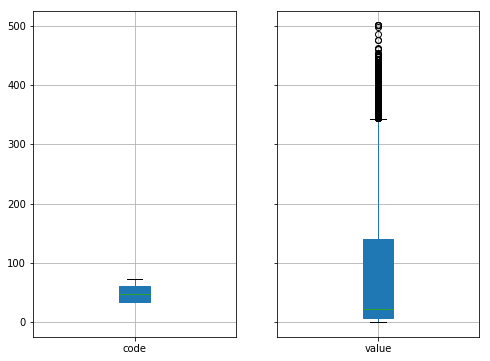

In [16]:
fig, axes = plt.subplots(ncols=2,sharex=False,sharey=True,figsize=(8,6))

df_clean.boxplot(column=['code'],ax=axes[0],patch_artist=True);
df_clean.boxplot(column=['value'],ax=axes[1],patch_artist=True);


#### General statistics and correlations

In [17]:
print(f'Amount data points: {len(df)}')

Amount data points: 29331


#### Date statistics

In [18]:
amount_dates = df['date'].nunique()
print(f'Amount days (uncleaned): {amount_dates}')

Amount days (uncleaned): 1141


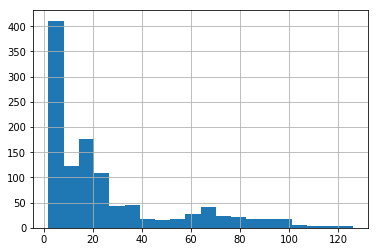

In [19]:
df.groupby('date').size().hist(bins=20)

In [20]:
min_per_day = df.groupby('date').size().min()
max_per_day = df.groupby('date').size().max()
print(f'Min. data points per day: {min_per_day}')
print(f'Min. data points per day: {max_per_day}')
print(df.groupby('date').size().describe(percentiles=[.75,.80,.95,.99]))

Min. data points per day: 2
Min. data points per day: 126
count    1141.000000
mean       25.676599
std        26.557611
min         2.000000
50%        16.000000
75%        31.000000
80%        42.000000
95%        86.000000
99%       106.200000
max       126.000000
dtype: float64


### data set description
1. The amount of data points per day is right-skewed -> 75% of days have less than 31, the remaining days hold between 32 and max 126 points
2. 

#### Time statistics

In [21]:
amount_times = df['time'].nunique()
print(f'Amount unique points in time (uncleaned): {amount_times}')

Amount unique points in time (uncleaned): 1311


#### Code statistics

In [22]:
amount_codes = df['code'].nunique()
print(f'Amount unique points in code (uncleaned): {amount_codes}')

Amount unique points in code (uncleaned): 24


#### Value statistics

In [23]:
amount_values = df['value'].nunique()
print(f'Amount unique points in value (uncleaned): {amount_values}')

Amount unique points in value (uncleaned): 744


# Classification


In [24]:
df_clean['target'] = df_clean['value'].apply(lambda x : x > 130)
df_clean['target'].value_counts()

False    21112
True      8011
Name: target, dtype: int64

We will translate the target column into a binary integer format. This is easier to work with 

In [25]:
df_clean['target'] = (df_clean['target'] == True).astype(int)

## Transformation and feature engineering

When Should I Use Log Transformation?
Many possible transformations exist. However, you should only use a log transformation if:

Your data is highly skewed to the right (i.e. in the positive direction).
(https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/skewed-distribution/)

In [ ]:
from sklearn.metrics import precision_recall_curve
y_train = [1]
y_scores = [1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

In [ ]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# Testing, sandbox area